#**SENTIMENT ANALYSIS**
###Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, (pd.read_csv)
import matplotlib.pyplot as plt
import math
import mlxtend
import sklearn.cluster as cluster
import sklearn.neighbors
import sklearn.metrics as metrics
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###Data Processing

In [5]:
train = pd.read_csv('train.txt', names = ['sentence', 'emotion'], header = None, sep = ";")
test = pd.read_csv('test.txt', names = ['sentence', 'emotion'], header = None, sep = ";")
val = pd.read_csv('val.txt', names = ['sentence', 'emotion'], header = None, sep = ";")
data = pd.concat([train, test, val])

In [6]:
data = data.drop_duplicates(keep="first") # Drop duplicated data and reindex the data
df = data.reset_index(drop=True)


In [7]:
df['label']=df['emotion'].replace({'joy':0, 'love': 1, 
                                   'sadness':2, 'anger':3, 'fear':4,'surprise':5})
df['length'] = df['sentence'].apply(len) # number of characters

In [5]:
df.head()

,sentence,emotion,label,length
0,i didnt feel humiliated,sadness,2,23
1,i can go from feeling so hopeless to so damned...,sadness,2,108
2,im grabbing a minute to post i feel greedy wrong,anger,3,48
3,i am ever feeling nostalgic about the fireplac...,love,1,92
4,i am feeling grouchy,anger,3,20


###Data Cleaning using NLP

In [8]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def decontracted(phrase):
    #contracted phrase into normal words
    
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"wouldnt", "would not", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"cudnt", "could not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesnt", "does not", phrase)
    phrase = re.sub(r"didnt", "did not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"havent", "have not", phrase)
    phrase = re.sub(r"hadnt", "had not", phrase)

    # general
    phrase = re.sub(r"n\ t", " not", phrase)
    #phrase = re.sub(r"\re", " are", phrase)
    phrase = re.sub(r"\ s ", " is ", phrase)
    phrase = re.sub(r"\ d ", " would ", phrase)
    phrase = re.sub(r"\ ll ", " will ", phrase)
    phrase = re.sub(r"\dunno", "do not ", phrase)
    phrase = re.sub(r"ive ", "i have ", phrase)
    phrase = re.sub(r"im ", "i am ", phrase)
    phrase = re.sub(r"i m ", "i am ", phrase)
    phrase = re.sub(r" w ", " with ", phrase)
    
    return phrase

def clean_text(df):
    cleaned_review = []

    for review_text in tqdm(df['sentence']):
        
        review_text = decontracted(review_text)
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip()

        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review  

df['cleaned_sentence'] = clean_text(df)
df.head()  


100%|██████████| 19999/19999 [00:06<00:00, 3332.22it/s]


,sentence,emotion,label,length,cleaned_sentence
0,i didnt feel humiliated,sadness,2,23,i did not feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,2,108,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,3,48,i am grabbing a minute to post i feel greedy w...
3,i am ever feeling nostalgic about the fireplac...,love,1,92,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,3,20,i am feeling grouchy


In [9]:
nltk.download('punkt')
def remove_stopwords(phrase):
    remove_sw = []
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    stop_words = stopwords.words('english')
    
    for review_text in tqdm(phrase):
        tokens = word_tokenize(review_text)
        tokens = [word for word in tokens if not word in stop_words]
        remove_sw.append(tokens)
    return remove_sw
df['cleaned_sentence'] = remove_stopwords(df['cleaned_sentence'])
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 19999/19999 [00:03<00:00, 5067.09it/s]


,sentence,emotion,label,length,cleaned_sentence
0,i didnt feel humiliated,sadness,2,23,"[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,2,108,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,3,48,"[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,1,92,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,3,20,"[feeling, grouchy]"


In [10]:
from nltk.stem import PorterStemmer

def stemming(phrase):
    stemmer = PorterStemmer()
    stem_output=[]
    stemmed=[]
    for review_text in tqdm(phrase):
        stemmed = [stemmer.stem(word) for word in review_text]
        stem_output.append(stemmed)
    return stem_output

df['cleaned_sentence'] = stemming(df['cleaned_sentence'])
df['cleaned_sentence'].head()

100%|██████████| 19999/19999 [00:05<00:00, 3834.34it/s]


0                                       [feel, humili]
1    [go, feel, hopeless, damn, hope, around, someo...
2             [grab, minut, post, feel, greedi, wrong]
3    [ever, feel, nostalg, fireplac, know, still, n...
4                                      [feel, grouchi]
Name: cleaned_sentence, dtype: object

In [11]:
def to_sentence(phrase):
    sentence=[]
    for words in tqdm(phrase):
        sentence.append((" ").join(words))
    return sentence
df['cleaned_sentence']=to_sentence(df['cleaned_sentence'])
df['cleaned_sentence'].head()

100%|██████████| 19999/19999 [00:00<00:00, 978385.56it/s]


0                                          feel humili
1    go feel hopeless damn hope around someon care ...
2                    grab minut post feel greedi wrong
3    ever feel nostalg fireplac know still noth pro...
4                                         feel grouchi
Name: cleaned_sentence, dtype: object

In [12]:
MAX_NB_WORDS = 15000
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 100

In [22]:
# load pre-trained model
import gensim.downloader as api
model_wiki = api.load('fasttext-wiki-news-subwords-300')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [20]:
from gensim.models import Word2Vec
# train word2vec model on the corpus
model_w2v = Word2Vec(df['cleaned_sentence'].values,   # data for model to train on
                 size = 100,                            # embedding vector size
                 min_count = 2).wv

In [23]:
def create_weight_matrix(model, second_model=False):
  '''
  Accepts word embedding model
  and the second model, if provided
  Returns weight matrix of size m*n, where
  m - size of the dictionary
  n - size of the word embedding vector

  '''
  vector_size = model.get_vector('like').shape[0]
  w_matrix = np.zeros((15000, vector_size))
  skipped_words = []

  for word, index in tokenizer.word_index.items():
    if index < 15000:
      if word in model.vocab.keys(): 
        w_matrix[index] = model.get_vector(word)
      else:
        if second_model:
          if word in second_model.vocab.keys():
            w_matrix[index] = second_model.get_vector(word)
          else:
            skipped_words.append(word)
        else:
          skipped_words.append(word)
 
  print(f'{len(skipped_words)} words were skipped. Some of them:')
  print(skipped_words[:50])
  return w_matrix
weight_matrix = create_weight_matrix(model_wiki, model_w2v)

4449 words were skipped. Some of them:
['realli', 'someth', 'pretti', 'everi', 'anyth', 'nothat', 'everyth', 'nothi', 'sometim', 'amaz', 'rememb', 'famili', 'alreadi', 'excit', 'irrit', 'angri', 'bodi', 'especi', 'realiz', 'frustrat', 'insid', 'confid', 'anxiou', 'pressur', 'sorri', 'slightli', 'terribl', 'peac', 'nothough', 'nervou', 'guilti', 'inspir', 'situat', 'suppos', 'particularli', 'beauti', 'horribl', 'worri', 'tortur', 'truli', 'belov', 'funni', 'terrifi', 'convinc', 'anymor', 'unhappi', 'lucki', 'positi', 'togeth', 'shitti']


In [13]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=15000, lower=True)
tokenizer.fit_on_texts(df['cleaned_sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#print(word_index)

Found 11976 unique tokens.


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['cleaned_sentence'].values)
X = pad_sequences(X, maxlen=35)
print('Shape of data tensor:', X.shape)
print(X)

Shape of data tensor: (19999, 35)
[[   0    0    0 ...    0    1  515]
 [   0    0    0 ...   56   90 1213]
 [   0    0    0 ...    1  428  190]
 ...
 [   0    0    0 ... 2508  238   17]
 [   0    0    0 ...  261  625 1572]
 [   0    0    0 ...  156    3   18]]


In [15]:
y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', y.shape)
print(y)

Shape of label tensor: (19999, 6)
[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [16]:
X_int = X.astype('int')
print(X_int)

[[   0    0    0 ...    0    1  515]
 [   0    0    0 ...   56   90 1213]
 [   0    0    0 ...    1  428  190]
 ...
 [   0    0    0 ... 2508  238   17]
 [   0    0    0 ...  261  625 1572]
 [   0    0    0 ...  156    3   18]]


In [17]:
y_int = y.astype('int')
y_int

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_int,y_int, test_size = 0.3, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(13999, 35) (13999, 6)
(6000, 35) (6000, 6)


###Model Training

###**BiLSTM** **Model**

In [24]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling1D, SpatialDropout1D, MaxPooling2D, Activation, LSTM, BatchNormalization, Bidirectional, CuDNNLSTM, Input, Conv1D
from tensorflow.keras.optimizers import SGD
from keras.models import load_model
from keras.layers.embeddings import Embedding
import tensorflow.keras
import tensorflow as tf

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
model = Sequential()
model.add(Embedding(input_dim = MAX_NB_WORDS, output_dim = weight_matrix.shape[1], input_length=X_int.shape[1], weights=[weight_matrix], trainable = False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2)))
#model.add(BatchNormalization())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

epochs = 20
batch_size = 8



In [27]:
history = model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, batch_size=batch_size,callbacks=[EarlyStopping(monitor='val_loss', mode = 'min',patience=3)])

Epoch 1/20
1400/1400 [==============================] - 790s 554ms/step - loss: 1.4565 - categorical_accuracy: 0.4357 - val_loss: 1.2887 - val_categorical_accuracy: 0.5161
Epoch 2/20
1400/1400 [==============================] - 766s 547ms/step - loss: 1.1747 - categorical_accuracy: 0.5591 - val_loss: 1.0294 - val_categorical_accuracy: 0.6275
Epoch 3/20
1400/1400 [==============================] - 753s 538ms/step - loss: 0.9916 - categorical_accuracy: 0.6309 - val_loss: 0.8955 - val_categorical_accuracy: 0.6721
Epoch 4/20
1400/1400 [==============================] - 714s 510ms/step - loss: 0.9076 - categorical_accuracy: 0.6586 - val_loss: 0.8623 - val_categorical_accuracy: 0.6714
Epoch 5/20
1400/1400 [==============================] - 715s 510ms/step - loss: 0.8676 - categorical_accuracy: 0.6678 - val_loss: 0.8464 - val_categorical_accuracy: 0.6743
Epoch 6/20
1400/1400 [==============================] - 718s 513ms/step - loss: 0.8262 - categorical_accuracy: 0.6854 - val_loss: 0.8243 - v

In [28]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

188/188 [==============================] - 39s 194ms/step - loss: 0.7718 - categorical_accuracy: 0.7140
Test set
  Loss: 0.772
  Accuracy: 0.714


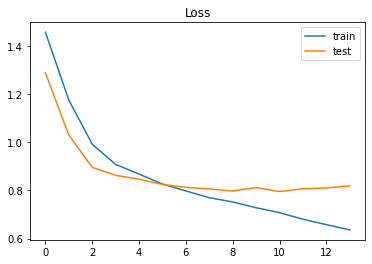

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

###Test On Custom Data

In [33]:
data = ['i still feel stupid to be in that class this is all cause off pbss fault']
tokenizer = Tokenizer(num_words=15000, lower=True)
seq = tokenizer.texts_to_sequences(data)
padded = pad_sequences(seq, maxlen=35)
pred = model.predict(padded)
labels = ['joy', 'love', 'sadness', 'anger', 'fear', 'surprise']
print(pred, labels[np.argmax(pred)])

[[0.21674278 0.00936516 0.13311689 0.37561932 0.25754988 0.00760594]] anger


In [30]:
def predict_sentiment(message):
  seq = tokenizer.texts_to_sequences(message)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  labels = ['joy', 'love', 'sadness', 'anger', 'fear', 'surprise']
  return(pred, labels[np.argmax(pred)])

In [31]:
m1 = ['i fell extremely comfortable with the group of people that i dont even need to hide myself ']
m2 = ['i stole a book from one of my all time favorite authors and now i feel like a rotten person']


print(predict_sentiment(m1))
print(predict_sentiment(m2))


(array([[0.14739415, 0.00412419, 0.15072691, 0.30419198, 0.3882751 ,
        0.00528759]], dtype=float32), 'fear')
(array([[9.9926940e-05, 1.2456632e-04, 9.9944490e-01, 7.6839315e-05,
        2.2374345e-04, 3.0035515e-05]], dtype=float32), 'sadness')


In [32]:
m3 = ['i feel a bit stressed even though all the things i have going on are fun']
m4 = ['i feel happy and excited!']

print(predict_sentiment(m3))
print(predict_sentiment(m4))

(array([[9.9637610e-01, 1.6560064e-03, 3.1706283e-04, 3.5701200e-04,
        1.0479202e-03, 2.4584791e-04]], dtype=float32), 'joy')
(array([[0.31225443, 0.02866103, 0.21793771, 0.21762682, 0.20343359,
        0.02008641]], dtype=float32), 'joy')


In [34]:
from keras.models import load_model
model.save('lstm_model.h5')